# Assignment
In this assignment, you'll continue working with the house prices data. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

- Load the houseprices data from Thinkful's database.
- Reimplement your model from the previous checkpoint.
- Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do k-fold cross-validation to choose the best hyperparameter values for your models. Scikit-learn has RidgeCV, LassoCV, and ElasticNetCV that you can utilize to do this. Which model is the best? Why?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


# get rid of the columns with nan. (since we don't need that many features)
df_drop = df.copy()
for col in df_drop.columns:
    if df_drop[col].isna().any():
#         print(col)
        df_drop = df_drop.drop(columns=col)
    
    
# in this practice, let's just take two categorical variables, I picked "street", "lotshape"
# Encode character string categorical data into numeric data using one hot encoding
df_encoded = pd.concat([df_drop, pd.get_dummies(df_drop["street"], drop_first=True)], axis=1)
df_encoded = pd.concat([df_encoded, pd.get_dummies(df_encoded["lotshape"], drop_first=True)], axis=1)



The number of observations in training set is 1168
The number of observations in test set is 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     288.4
Date:                Tue, 04 Feb 2020   Prob (F-statistic):          1.76e-102
Time:                        11:42:21   Log-Likelihood:                -14591.
No. Observations:                1168   AIC:                         2.919e+04
Df Residuals:                    1165   BIC:                         2.920e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

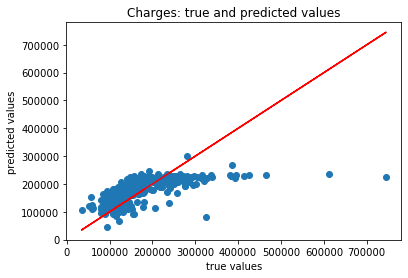

Mean absolute error of the prediction is: 42758.190059963665
Mean squared error of the prediction is: 4258385006.6042933
Root mean squared error of the prediction is: 65256.30242822752
Mean absolute percentage error of the prediction is: 25.01874903370775


In [10]:
# build the linear regression model
# use statsmodels, 
# OLS

# Y is the target variable
Y = df_drop['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = df_drop[['lotarea', 'yearbuilt']]


# split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))



X_train_w_constant = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train_w_constant).fit()
print(results.summary())


# evaluation using test set
X_test_w_constant = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test_w_constant)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


# intermideate sumary
after "Try(ing) to improve your model in terms of predictive performance by adding or removing some variables"

- from the predicted-true value plot visulazaiton, the ploted points are getting closer to ideal line, especially when our target value is lower, which indicated that the model has improved performance.
- we can see that in the test set, MAE, MSE, RMSE and MSPE values decreased, i.e. the MAPE is 25%, which has improved a lot. 



In [16]:
# build the linear regression model
# use statsmodels, 
# Ridge regreesion + cross validation (CV)
from sklearn.linear_model import RidgeCV

# Y is the target variable
Y = df_drop['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = df_drop[['lotarea', 'yearbuilt']]


# split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# making a list of alphas(lambdas)
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]


ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

# note: ridge_cv.alpha_ return the best alpha
print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))




The number of observations in training set is 1168
The number of observations in test set is 292
Best alpha value is: 10000.0
R-squared of the model in training set is: 0.3311531979212593
-----Test set statistics-----
R-squared of the model in test set is: 0.3650712998731567
Mean absolute error of the prediction is: 42764.74277565859
Mean squared error of the prediction is: 4262723403.9623713
Root mean squared error of the prediction is: 65289.53517955516
Mean absolute percentage error of the prediction is: 25.03299927838362


In [25]:
# build the linear regression model
# use statsmodels, 
# lasso regreesion + cross validation (CV)
from sklearn.linear_model import LassoCV

# Y is the target variable
Y = df_drop['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = df_drop[['lotarea', 'yearbuilt']]


# split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# making a list of alphas(lambdas)
# alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
alphas = [1000000]
alphas = [0.0000001]

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

# note: lasso_cv.alpha_ return the best alpha
print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))




The number of observations in training set is 1168
The number of observations in test set is 292
Best alpha value is: 1e-07
R-squared of the model in training set is: 0.33117562136584566
-----Test set statistics-----
R-squared of the model in test set is: 0.3657175001386037
Mean absolute error of the prediction is: 42758.19005996386
Mean squared error of the prediction is: 4258385006.6043415
Root mean squared error of the prediction is: 65256.30242822789
Mean absolute percentage error of the prediction is: 25.018749033708033


### short comment
it turned out that the alpha value does not significantly impact the result in this case. (I 've compared alpha = 1000000 and 0.0000001) 

In [26]:
# build the linear regression model
# use statsmodels, 
# lasso regreesion + cross validation (CV)
from sklearn.linear_model import ElasticNetCV

# Y is the target variable
Y = df_drop['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = df_drop[['lotarea', 'yearbuilt']]


# split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# making a list of alphas(lambdas)
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
# alphas = [1000000]
# alphas = [0.0000001]

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

# note: lasso_cv.alpha_ return the best alpha
print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))




The number of observations in training set is 1168
The number of observations in test set is 292
Best alpha value is: 10.0
R-squared of the model in training set is: 0.3311679026677353
-----Test set statistics-----
R-squared of the model in test set is: 0.3653433512993678
Mean absolute error of the prediction is: 42761.54002410433
Mean squared error of the prediction is: 4260896931.1924996
Root mean squared error of the prediction is: 65275.54619604879
Mean absolute percentage error of the prediction is: 25.026878651887372


### sumary

OLS:
Mean absolute error of the prediction is: 42758.190059963665
Mean squared error of the prediction is: 4258385006.6042933
Root mean squared error of the prediction is: 65256.30242822752
Mean absolute percentage error of the prediction is: 25.01874903370775

Ridge:
R-squared of the model in test set is: 0.3650712998731567
Mean absolute error of the prediction is: 42764.74277565859
Mean squared error of the prediction is: 4262723403.9623713
Root mean squared error of the prediction is: 65289.53517955516
Mean absolute percentage error of the prediction is: 25.03299927838362

Lasso:
R-squared of the model in test set is: 0.3657175001386037
Mean absolute error of the prediction is: 42758.19005996386
Mean squared error of the prediction is: 4258385006.6043415
Root mean squared error of the prediction is: 65256.30242822789
Mean absolute percentage error of the prediction is: 25.018749033708033

ElasticNet:
R-squared of the model in test set is: 0.3653433512993678
Mean absolute error of the prediction is: 42761.54002410433
Mean squared error of the prediction is: 4260896931.1924996
Root mean squared error of the prediction is: 65275.54619604879
Mean absolute percentage error of the prediction is: 25.026878651887372

It turned out the best model is OLS.

feture work: apply linear regression Cross- validation. at least calculate the R-score